In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
    
)
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
# read the csv file
df = pd.read_csv('F:\\MLOps\\Mlflow\\data\\titanic.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# check for missing values in data
(
    df
    .isna()
    .sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Cleaning


In [6]:
# columns to drop

columns_to_drop = ['passengerid', 'name', 'ticket', 'cabin']

In [7]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df:df['sibsp'] + df['parch']
        )
        .drop(columns=['sibsp','parch'])
    )

In [8]:
final_df = clean_data(df)

In [9]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [10]:
# shape of the cleaned Data

print(f'The Cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The Cleaned data has 891 rows and 7 columns


In [11]:
# missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
family        0
dtype: int64

# EDA

In [12]:
# distribution od target

(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [13]:
# boxplot

def create_boxplot(data, column_name, hue = None):
    sns.boxplot(data=data, y=column_name, hue=hue)

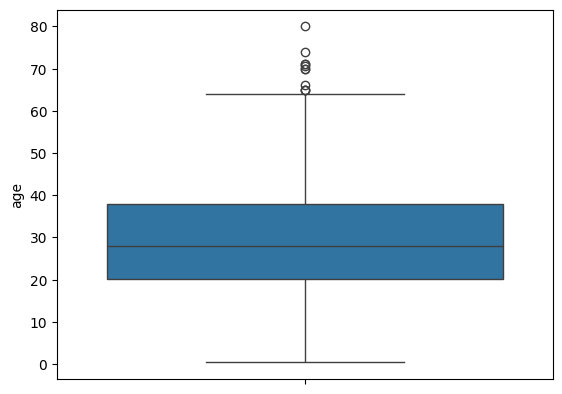

In [14]:
# boxplot for age column
create_boxplot(final_df, 'age')

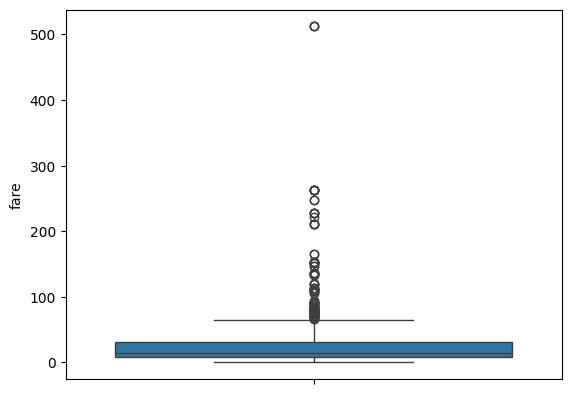

In [15]:
# boxplot for fare column

create_boxplot(final_df, 'fare')

In [16]:
# plot the distribution of categorical columns

def plot_distribution(data, column_name):
    sns.countplot(data=data, x=column_name)

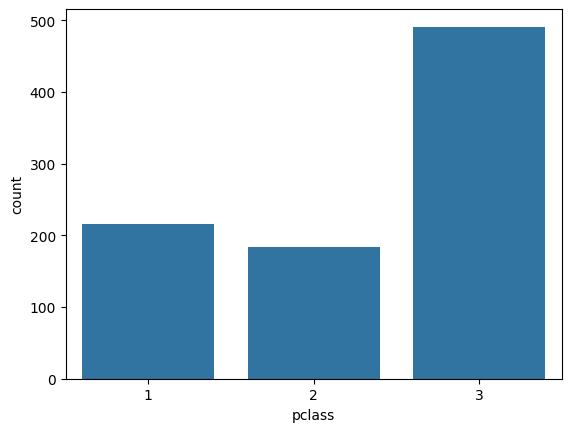

In [17]:
plot_distribution(final_df, 'pclass')

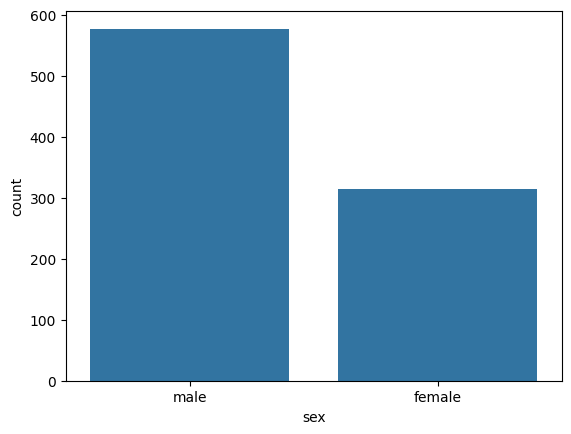

In [18]:
plot_distribution(final_df, 'sex')

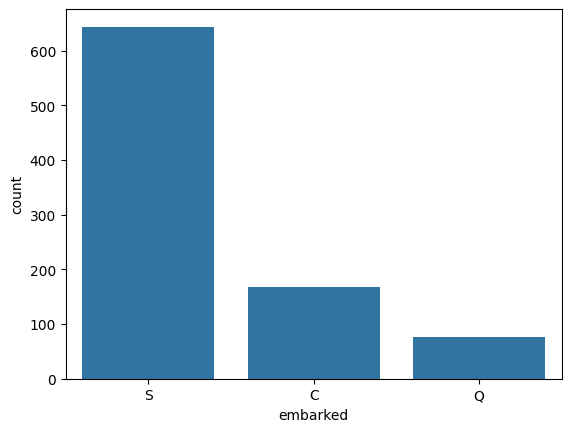

In [19]:
plot_distribution(final_df, 'embarked')

# Feature Engineering

In [20]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [21]:
# make X and y

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [22]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=38)

In [24]:
print('The shape of training data is', X_train.shape)
print('The shape of testing data is', X_test.shape)

The shape of training data is (712, 6)
The shape of testing data is (179, 6)


In [25]:
# age pipeline

age_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy = 'median')),
    ('outliers', Winsorizer(capping_method='gaussian', fold=3)),
    ('scale', StandardScaler())
])

In [26]:
age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [27]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
    ('scale', StandardScaler())
])

In [28]:
fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [29]:
# embarked pipeline

embarked_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method = 'count')),
    ('scale', MinMaxScaler())
])

In [30]:
embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

In [31]:
set_config(transform_output='pandas')

In [32]:
# make column transformer

preprocessor = ColumnTransformer(transformers = [
    ('age', age_pipe, ['age']),
    ('fare', fare_pipe, ['fare']),
    ('embarked', embarked_pipe, ['embarked']),
    ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['sex']),
    ('family', MinMaxScaler(), ['family'])
],remainder='passthrough', n_jobs = -1, force_int_remainder_cols = False)

In [33]:
preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [34]:
# fit and transform the training data 

preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
501,-0.639723,-0.804002,0.000000,1.0,0.0,0.0,3
704,-0.254386,-0.798778,1.000000,0.0,1.0,0.1,3
202,0.362153,-0.866877,1.000000,0.0,1.0,0.0,3
588,-0.562655,-0.788962,1.000000,0.0,1.0,0.0,3
523,1.132826,1.714080,0.175556,1.0,0.0,0.1,1
...,...,...,...,...,...,...,...
316,-0.408521,0.110904,1.000000,1.0,0.0,0.1,2
467,2.057635,0.138477,1.000000,0.0,1.0,0.0,1
53,-0.023184,0.110904,1.000000,1.0,0.0,0.1,2
843,0.400687,-0.869800,0.175556,0.0,1.0,0.0,3


In [35]:
preprocessor.get_params()

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer(fold=3)), ('s

In [36]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [49]:
model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.9,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [50]:
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(**model_params))
]
)

In [51]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_samples=0.9, n_jobs=-1,
                                        random_state=30))])

In [52]:
# fit the model on the training data

model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_samples=0.9, n_jobs=-1,
                                        random_state=30))])

In [53]:
y_pred = model_pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred).item()
recall = recall_score(y_test, y_pred).item()
f1 = f1_score(y_test, y_pred).item()

In [54]:
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score':f1
}

In [55]:
metrics

{'accuracy': 0.8379888268156425,
 'precision': 0.9310344827586207,
 'recall': 0.6835443037974683,
 'f1_score': 0.7883211678832117}

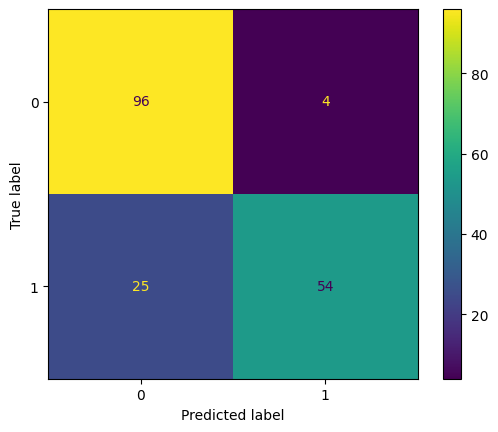

In [56]:
# plot confusion matrix

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

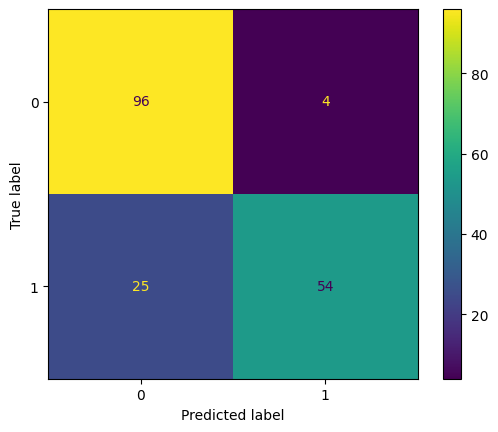

In [59]:
cm.figure_

# MLFlow Tracking

In [57]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                     remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                             

In [58]:
# check if uri is set

mlflow.is_tracking_uri_set()

True

**Run all the mlflow related tracking code in a single cell**

In [62]:
# Set the tracking uri

mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set an experiment name
mlflow.set_experiment("Titanic Data")

# mlflow logging starts from here
with mlflow.start_run(run_name = 'Sixth run') as run:
    
    # track input signature
    signature = mlflow.models.infer_signature(model_input = X_train, 
                                  model_output = model_pipe.predict(X_train))
    
    # log parameters
    mlflow.log_params(model_pipe.get_params())
    
    # log metrics
    mlflow.log_metrics(metrics)
    
    # log model
    mlflow.sklearn.log_model(sk_model=model_pipe, artifact_path='models', signature = signature)
    
    # log confusion matrix
    mlflow.log_figure(figure = cm.figure_, artifact_file = 'confusion_matrix.png')
    
    
    
    

f:\conda\envs\mlflow_env\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/09/22 06:15:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Sixth run at: http://127.0.0.1:5000/#/experiments/986332502159740868/runs/34935f88cb6542e49970865b37124a18.
2024/09/22 06:15:59 INFO mlflow.tracking._tracking_service.